In [35]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy

cos = nn.CosineSimilarity(dim=0, eps=1e-9)
device = "cuda"

# study 1 model's training with the new loss function with dist limits

# adjustable parameters
alpha_d = 100 # IID
local_ep = 5 
n_clients = 50 # dataset size for one client
mali_local_ep = 5
global attack 
attack = "untargeted" #"backdoor", "tlp", "ut"
model_name = "ConvNet" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"

In [36]:
def filter_trainable_state_dict(model):
    """
    Filters model.state_dict() to retain only parameters that are in model.parameters().

    Args:
        model (torch.nn.Module): The model whose state_dict needs filtering.

    Returns:
        dict: Filtered state dictionary containing only trainable parameters.
    """
    param_names = {name for name, _ in model.named_parameters()}
    return {k: v for k, v in model.state_dict().items() if k in param_names}

# # Example usage
# model = nn.Sequential(
#     nn.Linear(10, 5),
#     nn.BatchNorm1d(5),  # This has buffers (running_mean, running_var) in state_dict but not in parameters
#     nn.Linear(5, 2)
# )

# filtered_state_dict = filter_trainable_state_dict(model)
# print(filtered_state_dict.keys())  # Only includes trainable parameters


In [52]:
def cos_dist(w1, w2):
    """Compute cosine similarity between two flattened weight tensors"""
    w1_flat, w2_flat = torch.cat([p.view(-1) for p in w1]), torch.cat([p.view(-1) for p in w2])
    return 1 - torch.dot(w1_flat, w2_flat) / (torch.norm(w1_flat) * torch.norm(w2_flat))

def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    elif attack == "untargeted":
        asr = None
    return list(acc.values())[0], list(asr.values())[0]


def filter_trainable_state_dict(model):
    """
    Filters model.state_dict() to retain only parameters that are in model.parameters().

    Args:
        model (torch.nn.Module): The model whose state_dict needs filtering.

    Returns:
        dict: Filtered state dictionary containing only trainable parameters.
    """
    param_names = {name for name, _ in model.named_parameters()}
    return {k: v for k, v in model.state_dict().items() if k in param_names}


def train_rev_w_cos(model, loader, optimizer, scheduler, epochs, model0, model1, beta, budget):    
    model.train()
    # model.parameters need to use 
    flat_grad_model0 = flat_dict(filter_trainable_state_dict(model0))
    flat_grad_model1 = flat_dict(filter_trainable_state_dict(model1))
    grad_ben = (flat_grad_model1 - flat_grad_model0).to(device)
    
    losses = []
    running_loss, samples = 0.0, 0
    print(f"data length {len(loader) * loader.batch_size}: batches {len(loader)}, batch_size {loader.batch_size}")
    # check_point = filter_trainable_state_dict(model0).detach().clone()
    for ep in range(epochs):
        for it, (x, y) in enumerate(loader):
            if it % 2 == 0:
                losses.append(round(eval_epoch(model, loader), 2))
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss_ce = nn.CrossEntropyLoss(reduction="mean")(model(x), y)
            print(f"model(x), size{model(x).shape}, {model(x)}")
            print("y", y)
            print("loss_ce", loss_ce)
            # in the untraining reverse the sign of loss
            loss_ce = - loss_ce
            running_loss += loss_ce.item() * y.shape[0]
            samples += y.shape[0]
            
            # add cos loss 
            w = torch.cat([p.view(-1) for p in model.parameters()]).to(device)
            grad_mail = w - flat_grad_model0
            target = torch.ones(len(w)).to(device)
            loss_cos = nn.CosineEmbeddingLoss()(grad_ben.unsqueeze(0), grad_mail.unsqueeze(0), target)
            loss_obj = (1-beta) * loss_ce + beta * loss_cos
            loss_obj.backward()
            optimizer.step()
            scheduler.step()
            if it % 5 == 0:
                print(f"ep{ep}, loss_cs: {loss_ce:6f}, loss_cos: {loss_cos:6f}, loss_obj: {loss_obj:6f}, lr: {optimizer.param_groups[0]['lr']}")
        
        # break
        cos_d = cos_dist(grad_ben, grad_mail)
        print("eval losses", losses)
        print(f"cos_d: {cos_d}, budget: {budget}")
        
        if cos_d > budget:
            print(f"budget exceeded, finish training early, ep = {ep}")
            craft_g, k, cos_d2 = weighted_avg_budget_cos(a=grad_mail, 
                                                        b=grad_ben, 
                                                        budget=budget)
            print(f"crafted cos: {cos_d2}")
            restored_crafted = restore_dict_grad_flat(craft_g, model0.state_dict(), model.state_dict())
            model.load_state_dict(restored_crafted)
            break
        # else:
            # check_point = model.state_dict().detach().clone()
        

    return {"loss": running_loss / samples}
    

In [50]:
# Define transformation (convert images to tensors and normalize)
transform_img = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

if dataset == "fmnist":
    # Load the training dataset
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_img)
    # Load the test dataset
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_img)
elif dataset == "cifar10":
    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_img)
    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_img)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models 
model0 = model_fn().to(device) # orginal model
model1 = model_fn().to(device) # train with clean data
model2 = model_fn().to(device) # train with new loss function
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer0 = optim.SGD(model0.parameters(), lr=0.001)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)

optimizer3 = optim.SGD(model3.parameters(), lr=0.001)



Data split:
 - Client 0: [122 121 123 115 115 111 126 139 112 110]               -> sum=1194
 - Client 1: [127 114 132 112 128 124 111 114 123 115]               -> sum=1200
 - Client 2: [108 111 114 117 117 141 119 125 127 122]               -> sum=1201
 - Client 3: [123 110 109 118 124 138 108 115 122 132]               -> sum=1199
 - Client 4: [116 128 138 104 127 121 114 118 116 120]               -> sum=1202
 - Client 5: [104 127  99 137 125 128 111 111 127 131]               -> sum=1200
 - Client 6: [117 129 124 139 114 110 128 117 102 120]               -> sum=1200
 - Client 7: [107 116 117 112  98 109 138 113 151 138]               -> sum=1199
 - Client 8: [134 123 121  96 125 137 107 105 123 130]               -> sum=1201
 - Client 9: [114 110 125 147  91 103 133 118 121 136]               -> sum=1198
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 41: [122 107 131 121 126 109 118 107 139 120]               -> sum=1200
 - 

In [39]:
# model1 train benign
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)



[2.35, 2.3, 2.26, 2.21, 2.17, 2.12, 2.09, 2.05, 2.01, 1.98, 1.95, 1.92, 1.89, 1.86, 1.83, 1.81, 1.79, 1.77, 1.75, 1.73, 1.71, 1.69, 1.67, 1.65, 1.63, 1.62, 1.6, 1.58, 1.57, 1.55, 1.54, 1.53, 1.51, 1.5, 1.48, 1.47, 1.46, 1.45, 1.44, 1.43, 1.42, 1.41, 1.4, 1.38, 1.37, 1.37, 1.36, 1.35, 1.34, 1.33, 1.32, 1.31, 1.3, 1.29, 1.28, 1.27, 1.27, 1.26, 1.25, 1.24, 1.23, 1.23, 1.22, 1.21, 1.21, 1.2, 1.19, 1.19, 1.18, 1.17, 1.17, 1.16, 1.16, 1.15, 1.15, 1.14, 1.13, 1.13, 1.12, 1.12, 1.11, 1.11, 1.1, 1.1, 1.09, 1.09, 1.08, 1.07, 1.07, 1.07, 1.06, 1.06, 1.05, 1.05, 1.04]


{'loss': 1.4477986973134715}

In [40]:
model1_sd = {key: value.clone() for key, value in model1.state_dict().items()}

model1_result = eval_op_ensemble([model1], test_loader)
print("model1_result", model1_result)

model1_result {'test_accuracy': 0.727}


In [41]:
def restore_dict_grad_dict(grad_dict, server_w, model_dict):
    state_dict_keys = set(model_dict.keys())
    param_dict_keys = set(server_w.keys())
    
    missing_keys = state_dict_keys - param_dict_keys    
    
    print("grad_dict", grad_dict)
    print("server_w", server_w)
    
    restored_w = {}

    for name, param in model_dict.items():
        if name not in missing_keys:
            print("name", name)
            print(grad_dict[name].shape, server_w[name].shape)

            restored_w[name] = grad_dict[name] + server_w[name]                           

        else:
            restored_w[name] = model_dict[name]
    return restored_w

In [53]:
# model2 train with new loss function
optimizer2 = optim.SGD(model2.parameters(), lr=0.05) # 0.001
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.95)

model2.load_state_dict(model1_sd)
train_rev_w_cos(model2, client_loader, optimizer2, scheduler2, epochs=8, 
                                model0 = model0, 
                                model1 = model1, 
                                beta = 0.5, 
                                budget = 0.1)

data length 1216: batches 38, batch_size 32


model(x), sizetorch.Size([32, 10]), tensor([[-0.2689, -0.5623, -1.0158, -0.1950, -0.8226,  0.6257, -0.3308,  1.0212,
          0.4087,  2.9841],
        [ 1.7131,  0.4593,  0.3919,  1.3029,  0.4459, -1.8763,  0.9416, -1.3696,
         -0.6200, -0.9170],
        [ 0.4353, -1.0402,  0.7381,  0.4667,  0.9534, -1.1479,  0.8689, -1.2461,
          0.3501, -1.1417],
        [ 0.3523,  2.8817, -0.7536,  1.6360, -0.4029, -0.7863, -0.0979, -0.5565,
         -0.8770, -0.4496],
        [ 0.9152, -0.6645,  0.7119,  0.4295,  0.9356, -0.9383,  1.1982, -1.4538,
          0.2379, -1.5836],
        [ 1.2954, -1.1222,  1.0025,  0.4308,  0.5932, -1.6827,  1.2210, -1.1300,
          0.2958, -1.5679],
        [-0.9734, -0.3402, -0.7521, -0.5735, -0.8771,  1.9052, -0.6352,  2.6940,
          0.4252,  0.9151],
        [-1.3886, -1.0625, -0.1078, -1.0950, -0.0466,  0.8518, -0.4810,  1.7949,
          2.0978,  0.4517],
        [ 0.3518, -1.4358,  1.7709, -0.1320,  1.1912, -1.4081,  1.4411, -1.4255,
          0

{'loss': -1605.4140338386524}

In [45]:
optimizer2

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.05
    lr: 0.04286875
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [43]:

cos_d_model1_2 = cos_dist(flat_dict(model1.state_dict()) - flat_dict(model0.state_dict()), 
                          flat_dict(model2.state_dict()) - flat_dict(model0.state_dict()))
print("model1_2 cos dist", cos_d_model1_2)



model1_2 cos dist tensor(0.0034, device='cuda:0')


In [14]:
cos_dist(flat_dict(filter_trainable_state_dict(model1)) - flat_dict(filter_trainable_state_dict(model0)),
         flat_dict(filter_trainable_state_dict(model2)) - flat_dict(filter_trainable_state_dict(model0)))

tensor(0.0035, device='cuda:0')

In [46]:
model2_result = eval_op_ensemble([model2], test_loader)
print("model2_result", model2_result)

model2_result {'test_accuracy': 0.1}


In [ ]:
model1.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[ 0.0613, -0.0275,  0.2202],
                        [ 0.0242,  0.1756, -0.2839],
                        [-0.1478,  0.2592, -0.2472]]],
              
              
                      [[[-0.0114,  0.1287, -0.0115],
                        [ 0.3173, -0.2873,  0.1135],
                        [-0.1041, -0.3322, -0.2713]]],
              
              
                      [[[-0.2120,  0.2647,  0.1445],
                        [-0.1276, -0.2407,  0.2731],
                        [ 0.0399,  0.2029,  0.1159]]],
              
              
                      ...,
              
              
                      [[[ 0.1498,  0.2122,  0.1164],
                        [ 0.1134,  0.2563,  0.1857],
                        [ 0.2865,  0.0301, -0.1244]]],
              
              
                      [[[ 0.2479, -0.3254, -0.1642],
                        [-0.3118, -0.1609,  0.1739],
                        [ 0.0314, -0.1

In [16]:
# visualization of the layers

import torch
import numpy as np
import matplotlib.pyplot as plt

def compare_model_weights(model1, model2):
    """
    Compare the weights of two PyTorch models layer by layer using bar charts.
    
    Args:
        model1 (torch.nn.Module): The first model to compare.
        model2 (torch.nn.Module): The second model to compare.
    
    Returns:
        None (displays a bar chart of L2 distance and cosine dissimilarity).
    """
    layer_names = []
    l2_distances = []
    cos_dissimilarities = []
    
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Layer mismatch: {name1} vs {name2}")
        
        layer_names.append(name1)
        param1_flat = param1.view(-1)
        param2_flat = param2.view(-1)
        
        l2_distance = torch.norm(param1_flat - param2_flat, p=2).item()
        l2_distances.append(l2_distance)
        
        cos_sim = torch.nn.functional.cosine_similarity(param1_flat, param2_flat, dim=0).item()
        cos_dissimilarities.append(1 - cos_sim)
    
    
    flat_grad_model1 = flat_dict(filter_trainable_state_dict(model1))
    flat_grad_model2 = flat_dict(filter_trainable_state_dict(model2))
    layer_names.append("all")
    
    l2_distance = torch.norm(flat_grad_model1 - flat_grad_model2, p=2).item()
    l2_distances.append(l2_distance)
        
    cos_sim = torch.nn.functional.cosine_similarity(flat_grad_model1, flat_grad_model2, dim=0).item()
    cos_dissimilarities.append(1 - cos_sim)
    
    # Plot results as bar charts
    x = np.arange(len(layer_names))  # Layer indices
    width = 0.35  # Width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Bar chart for L2 Distance
    ax1.bar(x - width/2, l2_distances, width, label="L2 Distance", color='tab:blue')
    ax1.set_xlabel("Layer")
    ax1.set_ylabel("L2 Distance", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Bar chart for Cosine Dissimilarity
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, cos_dissimilarities, width, label="Cos Disimilarity", color='tab:red')
    ax2.set_ylabel("Cos Disimilarity", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Add layer names to x-axis
    plt.xticks(x, layer_names, rotation=45, ha='right')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    
    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Add title and layout adjustments
    plt.title("Layer-wise L2 Distance and Cosine Dissimilarity (Bar Chart)")
    # fig.tight_layout()
    plt.show()

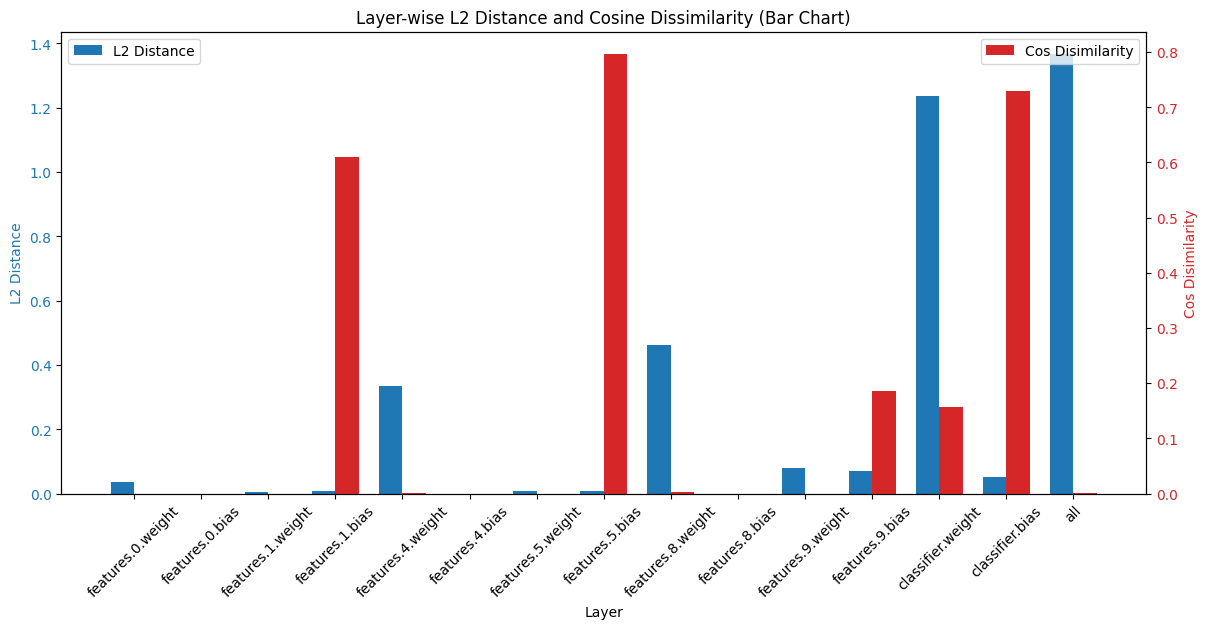

In [17]:
compare_model_weights(model1, model2)

The L2 and Cosine distince is small in this attack

In [ ]:
import torch.nn as nn

# Example model
model = nn.Sequential(
    nn.Linear(10, 5),
    nn.BatchNorm1d(5),  # This has buffers (running_mean, running_var) in state_dict but not in parameters
    nn.Linear(5, 2)
)

# Get parameter names (those in model.parameters())
param_names = {name for name, param in model.named_parameters()}

# Filter state_dict keys that are in param_names
filtered_state_dict = {k: v for k, v in model.state_dict().items() if k in param_names}

# Display results
print(filtered_state_dict.keys())  # Only includes layers that are in model.parameters()


dict_keys(['0.weight', '0.bias', '1.weight', '1.bias', '2.weight', '2.bias'])


In [19]:
import torch
import torch.nn.functional as F

# Define a reference tensor X
X = torch.tensor([1.0, 2.0, 3.0])

# Construct two different tensors A and B that are not scalar multiples but have the same cosine similarity to X
A = torch.tensor([2.0, 0.0, 1.0])  
B = torch.tensor([1.0, 3.0, 0.0])  

# Compute cosine similarities
cos_sim_A = F.cosine_similarity(A.unsqueeze(0), X.unsqueeze(0), dim=1)
cos_sim_B = F.cosine_similarity(B.unsqueeze(0), X.unsqueeze(0), dim=1)

print(f"Cosine similarity of A and X: {cos_sim_A.item()}")
print(f"Cosine similarity of B and X: {cos_sim_B.item()}")


Cosine similarity of A and X: 0.5976142883300781
Cosine similarity of B and X: 0.591607928276062
